# Описание
В настоящее время количество выходящих в течение года научных публикаций велико и растёт экспоненциально во многих областях, в связи с чем открывается простор для создания автоматических инструментов, помогающих в поиске и обработке информации. В частности, веб-сервис [PubTrends](https://pubtrends.net/) позволяет взглянуть на множество статей, соответствующих поисковому запросу, как на единое целое, выделяя подразделы научных направлений, динамику их развития и тем самым структурируя результаты выдачи.
В рамках текущего проекта предлагается добавить в список возможностей сервиса извлечение численных показателей, а также визуализацию результатов и возможность фильтрации статей на основе извлеченных значений. Такая функциональность может быть полезна, например, в биомедицинской литературе для поиска статей с большим количеством испытуемых, а в технической - для получения представления о получаемых значений целевой метрики в рамках различных задач.
Для извлечения численных показателей из текста уже существуют инструменты, такие как [grobid-quantities](https://grobid-quantities.readthedocs.io/en/latest/) или [marve](https://arxiv.org/pdf/1710.04312.pdf). Фокус этой практики будет обращен именно на агрегацию информации из множества статей и использование этой информации для фильтрации статей. Первоначально разработка будет вестись в рамках Jupyter Notebook, при успешном выполнении задач планируется интеграция модуля в существующий веб-сервис.

*Почему вам интересен этот проект?*

В моей научной деятельности, которая завязана на эксперименте и моделировании, численные величины часто определяют суть работы. Например, эксперименты при разных температурах (от комнатной до гелиевой) могут кардинально отличаться по используемым методам и применяемым моделям. Такая информация не всегда явно выделяется словесным описанием, и было бы удобно иметь инструмент для её извлечения и классификации работ по некоторым численным показателям. Вопросы к цифрам в публикациях коллег по области возникают достаточно часто в моей работе, поэтому мне было бы крайне интересно принять участие в таком проекте, довести его до реализации и в перспективе пользоваться таким инструментом.


# Задача 1
Задачи

Установить [grobid-quantities](https://grobid-quantities.readthedocs.io/en/latest/)

Скачать CSV файл с информацией о статьях по [ссылке](https://drive.google.com/file/d/1d3NJbq7EInZYl8Q5Pb7YfAwQUVxZ9FdE/view?usp=sharing).
Загрузить данные из CSV. Файл содержит две колонки: PMID (идентификатор статьи в базе Pubmed) и abstract (текст аннотации).

Используя REST API запущенного локально сервиса grobid-quantities, извлечь все численные показатели из аннотаций статей. В рамках этого задания достаточно поддержать только тип значений value (см. [документацию](https://grobid-quantities.readthedocs.io/en/latest/restAPI.html#response-description) grobid-quantities).

Построить гистограмму извлеченных значений, относящихся к слову ‘accuracy’ в текстах аннотаций.

In [1]:
# %cd /content/drive/MyDrive/CSC/2022_spring_internship/JB_SHK2
!pip install -r requirements.txt 

In [2]:
import grobid_quantities.quantities 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_orig = pd.read_csv('2022_JBR_Spring_Internship_Test_Data.csv')
df_orig.loc[437, 'abstract'] = ''.join([
    'The average classification accuracy was 67.9% and 75.7% for covert and overt speech, ',
    'respectively; this was 5-10 % lower than the movement classification. The performance ',
    'of the combined movement-speech decoder was 61.9% and 67.7% (covert and overt), ',
    'but it is possible to have more classes available for control.'
]) # row 437 has broken markdown, which is fixed by the easiest way - manually 

server_url = 'http://localhost:8060/service/'

from grobid_quantities.quantities import QuantitiesClient
client = QuantitiesClient(apiBase=server_url)

Skim through csv table suggests that all accurancies are represented in percents, so as a naive approach, let's extract percentages and check if words accuracy/accuracies are present in an abstract. Then we regard these occurences as accuracies and plot histogram.

In [3]:
def retrieve_acc1(text):
    text = text.replace('\u2009', '').replace('\u202f', '').replace('\u200a', '') # deleting unicodes
                                                                                  # invoking response 500 
    data = client.process_text(text) 
    quants = []
    if data[0] != 200:
        print("response ", data[0])
        return None
    if 'measurements' not in data[1].keys():
        return []
    
    for meas in data[1]['measurements']:
        if (
        meas['type'] == 'value'
        and 'normalizedUnit' in meas['quantity'].keys()
        and meas['quantity']['normalizedUnit'] == {'name': 'one'}
        ):
            quant = meas['quantity']['normalizedQuantity']
            if quant > 0 and quant < 1: quants.append(quant)
    return quants

df = df_orig
df['word accuracy'] = ['accurac' in df.loc[i, 'abstract'] for i in range(len(df))]
df['accuracy'] = [retrieve_acc1(df['abstract'][i]) for i in range(len(df))]
df

,PMID,abstract,word accuracy,accuracy
0,35103873,It has been a challenge for solving the motor ...,True,[]
1,35095410,The development of reliable assistive devices ...,False,[]
2,35093844,Identifying motor and mental imagery electroen...,True,[0.9952]
3,35090904,Brain computer interface (BCI) utilizes brain ...,True,"[0.7181, 0.8314]"
4,35088740,Brain-computer interface (BCI)-controlled func...,False,[]
...,...,...,...,...
1424,11482363,The electroencephalogram (EEG) is modified by ...,True,[]
1425,11204035,Electroencephalogram (EEG) recordings during r...,True,[0.14]
1426,10896191,We present an overview of our research into br...,False,[]
1427,10478710,EEG feedback studies demonstrate that human su...,True,[0.85]


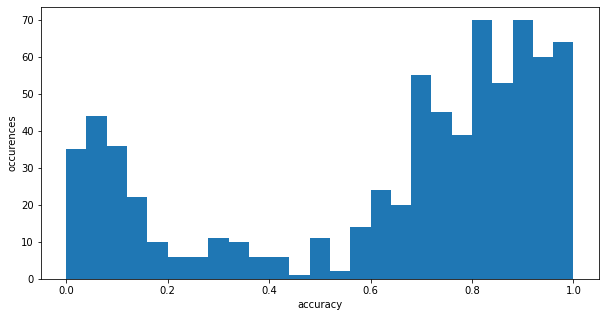

In [5]:
occurences = []
for quants in df[df['word accuracy'] == True]['accuracy']:
    occurences += quants

plt.figure(figsize=(10,5))
plt.hist(occurences, 25)
plt.xlabel('accuracy')
plt.ylabel('occurences')
plt.show()

The resulted occurences probably represent the real ones considering the rigidity of implemented approach. On the other side, this rigidity leads to non-zero amount of false-positive and false-negative occurences.

We'll try to downsize false occurences using rather advanced filtering: counting a number in if there is "accurac" word near: -100 offset before the number and +30 offset after. Let's take as the property of an english sentence construction that if "accuracy" apears before it might be very far away from the number, but if after - it usually stands nearby. 

In [6]:
def retrieve_acc2(text):
    text = text.replace('\u2009', '').replace('\u202f', '').replace('\u200a', '') # deleting unicodes
                                                                                  # invoking response 500 
    data = client.process_text(text) 
    quants = []
    if data[0] != 200:
        print("response ", data[0])
        return None
    if 'measurements' not in data[1].keys():
        return []
    
    for meas in data[1]['measurements']:
        if (
        meas['type'] == 'value'
        and 'normalizedUnit' in meas['quantity'].keys()
        and meas['quantity']['normalizedUnit'] == {'name': 'one'}
        ):
            quant = meas['quantity']['normalizedQuantity']
            meas_pos = meas['quantity']['offsetStart']
            offset = 'accurac' in text[meas_pos-100 : meas_pos+30]
            if quant > 0 and quant < 1 and offset: quants.append(quant)
                
    return quants

df2 = df_orig
df2['accuracy'] = [retrieve_acc2(df2['abstract'][i]) for i in range(len(df2))]
df2

,PMID,abstract,word accuracy,accuracy
0,35103873,It has been a challenge for solving the motor ...,True,[]
1,35095410,The development of reliable assistive devices ...,False,[]
2,35093844,Identifying motor and mental imagery electroen...,True,[0.9952]
3,35090904,Brain computer interface (BCI) utilizes brain ...,True,"[0.7181, 0.8314]"
4,35088740,Brain-computer interface (BCI)-controlled func...,False,[]
...,...,...,...,...
1424,11482363,The electroencephalogram (EEG) is modified by ...,True,[]
1425,11204035,Electroencephalogram (EEG) recordings during r...,True,[]
1426,10896191,We present an overview of our research into br...,False,[]
1427,10478710,EEG feedback studies demonstrate that human su...,True,[]


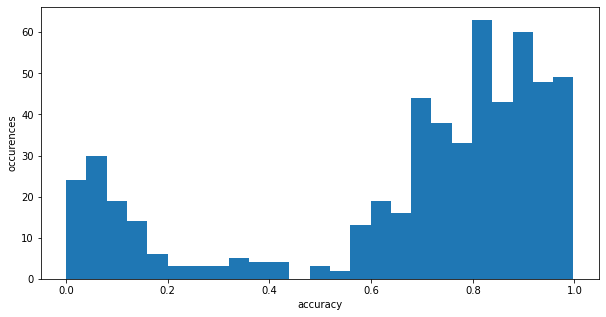

In [7]:
occurences = []
for quants in df2['accuracy']:
    occurences += quants

plt.figure(figsize=(10,5))
plt.hist(occurences, 25)
plt.xlabel('accuracy')
plt.ylabel('occurences')
plt.show()

The overall number of occurences is smaller than in the first approach, however the profile of histograms are pretty similar. Probably, true occurences were cut as well. 

Summing up, a simple solution based on the vicinity of "accuracy/ies" to percentages is presented. I would say that in order to solve the suggested problem precisely, one needs to implement ML approaches and analyze the relevance of a numbers to a word "accuracy".